# Anomaly Detection with Liquid Neural Networks

This notebook demonstrates how to use liquid neural networks (CfC and LTC) for time series anomaly detection. We'll cover:
- Reconstruction-based anomaly detection
- Time-aware anomaly scoring
- Comparison of CfC and LTC approaches
- Real-world application examples

In [1]:
import mlx.core as mx
import mlx.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from ncps.mlx import CfC, LTC
from sklearn.preprocessing import StandardScaler
import pandas as pd

## Create Anomaly Detection Models

We'll implement autoencoder-style models using liquid neurons:

In [2]:
class LiquidAutoencoder(nn.Module):
    """Autoencoder using liquid neurons for anomaly detection."""
    
    def __init__(self, input_size, hidden_size, cell_type='cfc'):
        super().__init__()
        # Encoder
        self.encoder = CfC if cell_type == 'cfc' else LTC
        self.encoder = self.encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            backbone_units=64,
            backbone_layers=2,
            return_sequences=True
        )
        
        # Decoder
        self.decoder = self.encoder(
            input_size=hidden_size,
            hidden_size=input_size,
            num_layers=2,
            backbone_units=64,
            backbone_layers=2,
            return_sequences=True
        )
    
    def __call__(self, x, time_delta=None):
        # Encode
        encoded = self.encoder(x, time_delta=time_delta)
        # Decode
        decoded = self.decoder(encoded, time_delta=time_delta)
        return decoded
    
    def compute_anomaly_score(self, x, time_delta=None):
        """Compute reconstruction error as anomaly score."""
        reconstructed = self(x, time_delta=time_delta)
        # Use time-weighted MSE if time_delta is provided
        if time_delta is not None:
            weights = 1.0 / (time_delta + 1e-6)  # Avoid division by zero
            error = (x - reconstructed) ** 2
            return mx.mean(error * weights, axis=-1)
        return mx.mean((x - reconstructed) ** 2, axis=-1)

## Generate Synthetic Data with Anomalies

ValueError: Cannot index mlx array using the given type yet

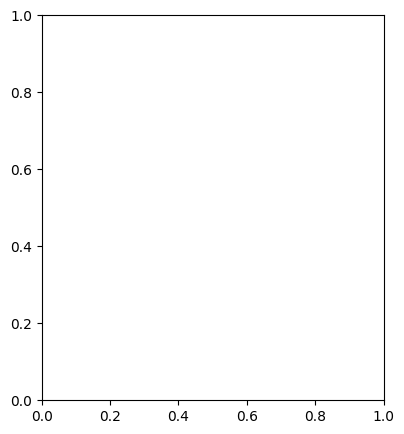

In [3]:
def generate_anomaly_data(n_samples=1000, seq_length=50, n_features=3, anomaly_ratio=0.1):
    """Generate synthetic time series with anomalies."""
    # Generate normal data
    t = np.linspace(0, 4*np.pi, seq_length)
    normal_data = np.zeros((n_samples, seq_length, n_features))
    
    for i in range(n_samples):
        # Generate multiple frequency components
        freq = 1.0 + 0.1 * np.random.randn()
        phase = 2 * np.pi * np.random.rand()
        
        for j in range(n_features):
            normal_data[i, :, j] = np.sin(freq * t + phase + j*np.pi/3)
    
    # Add noise
    normal_data += 0.1 * np.random.randn(*normal_data.shape)
    
    # Generate anomalies
    n_anomalies = int(n_samples * anomaly_ratio)
    anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
    
    for idx in anomaly_indices:
        # Random anomaly type
        anomaly_type = np.random.choice(['spike', 'shift', 'trend'])
        
        if anomaly_type == 'spike':
            # Add sudden spikes
            spike_idx = np.random.randint(seq_length)
            normal_data[idx, spike_idx] += 3 * np.random.randn(n_features)
        elif anomaly_type == 'shift':
            # Add level shifts
            shift_idx = np.random.randint(seq_length)
            normal_data[idx, shift_idx:] += 2 * np.random.randn(n_features)
        else:
            # Add abnormal trends
            trend = np.linspace(0, 2, seq_length)[:, None] * np.random.randn(n_features)
            normal_data[idx] += trend
    
    # Create labels
    labels = np.zeros(n_samples)
    labels[anomaly_indices] = 1
    
    # Generate variable time steps
    time_delta = np.ones((n_samples, seq_length, 1))
    for i in range(n_samples):
        time_delta[i] += 0.1 * np.random.randn(seq_length, 1)
    
    return mx.array(normal_data), mx.array(time_delta), labels

# Generate data
X, time_delta, labels = generate_anomaly_data()

# Plot example sequences
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    idx = np.where(labels == i%2)[0][0]
    plt.plot(X[idx, :, 0])
    plt.title(f"{'Anomaly' if labels[idx] == 1 else 'Normal'} Sequence")
plt.tight_layout()
plt.show()

## Train Models

In [ ]:
def train_anomaly_detector(model, X, time_delta, n_epochs=100, batch_size=32):
    """Train the anomaly detection model."""
    optimizer = nn.Adam(learning_rate=0.001)
    
    def loss_fn(model, x, dt):
        reconstructed = model(x, time_delta=dt)
        return mx.mean((x - reconstructed) ** 2)
    
    loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
    n_samples = X.shape[0]
    losses = []
    
    for epoch in range(n_epochs):
        epoch_losses = []
        # Shuffle data
        indices = np.random.permutation(n_samples)
        
        for i in range(0, n_samples, batch_size):
            batch_idx = indices[i:i+batch_size]
            batch_X = X[batch_idx]
            batch_dt = time_delta[batch_idx]
            
            loss, grads = loss_and_grad_fn(model, batch_X, batch_dt)
            optimizer.update(model, grads)
            epoch_losses.append(float(loss))
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    
    return losses

# Train CfC model
print("Training CfC model...")
cfc_model = LiquidAutoencoder(input_size=3, hidden_size=32, cell_type='cfc')
cfc_losses = train_anomaly_detector(cfc_model, X, time_delta)

# Train LTC model
print("\nTraining LTC model...")
ltc_model = LiquidAutoencoder(input_size=3, hidden_size=32, cell_type='ltc')
ltc_losses = train_anomaly_detector(ltc_model, X, time_delta)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(cfc_losses, label='CfC')
plt.plot(ltc_losses, label='LTC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate Anomaly Detection

In [ ]:
def evaluate_detector(model, X, time_delta, labels, threshold_percentile=95):
    """Evaluate anomaly detection performance."""
    # Compute anomaly scores
    scores = model.compute_anomaly_score(X, time_delta=time_delta)
    scores = mx.mean(scores, axis=1)  # Average over sequence length
    
    # Determine threshold
    threshold = np.percentile(scores, threshold_percentile)
    predictions = (scores > threshold).astype(np.int32)
    
    # Compute metrics
    tp = np.sum((predictions == 1) & (labels == 1))
    fp = np.sum((predictions == 1) & (labels == 0))
    fn = np.sum((predictions == 0) & (labels == 1))
    tn = np.sum((predictions == 0) & (labels == 0))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'scores': scores,
        'threshold': threshold
    }

# Evaluate models
cfc_results = evaluate_detector(cfc_model, X, time_delta, labels)
ltc_results = evaluate_detector(ltc_model, X, time_delta, labels)

print("CfC Results:")
print(f"Precision: {cfc_results['precision']:.4f}")
print(f"Recall: {cfc_results['recall']:.4f}")
print(f"F1 Score: {cfc_results['f1']:.4f}")

print("\nLTC Results:")
print(f"Precision: {ltc_results['precision']:.4f}")
print(f"Recall: {ltc_results['recall']:.4f}")
print(f"F1 Score: {ltc_results['f1']:.4f}")

# Plot score distributions
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.hist(cfc_results['scores'][labels == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(cfc_results['scores'][labels == 1], bins=50, alpha=0.5, label='Anomaly')
plt.axvline(cfc_results['threshold'], color='r', linestyle='--', label='Threshold')
plt.title('CfC Score Distribution')
plt.legend()

plt.subplot(122)
plt.hist(ltc_results['scores'][labels == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(ltc_results['scores'][labels == 1], bins=50, alpha=0.5, label='Anomaly')
plt.axvline(ltc_results['threshold'], color='r', linestyle='--', label='Threshold')
plt.title('LTC Score Distribution')
plt.legend()

plt.tight_layout()
plt.show()

## Real-World Example: Server Metrics

Let's apply our models to a real-world scenario using server metrics data:

In [ ]:
def load_server_metrics():
    """Simulate loading server metrics data."""
    # Generate realistic server metrics
    n_samples = 1000
    seq_length = 60  # 1 hour of minute-level data
    
    metrics = {
        'cpu_usage': [],
        'memory_usage': [],
        'network_traffic': [],
        'response_time': []
    }
    
    t = np.linspace(0, 2*np.pi, seq_length)
    
    for _ in range(n_samples):
        # CPU usage: Daily pattern with noise
        cpu = 50 + 30*np.sin(t) + 5*np.random.randn(seq_length)
        
        # Memory usage: Gradual increase with periodic cleanup
        memory = np.minimum(100, 60 + np.cumsum(0.1*np.random.randn(seq_length)))
        
        # Network traffic: Spiky pattern
        network = 500 + 200*np.sin(t) + 50*np.random.exponential(1, seq_length)
        
        # Response time: Usually stable with occasional spikes
        response = 100 + 10*np.random.randn(seq_length)
        
        metrics['cpu_usage'].append(cpu)
        metrics['memory_usage'].append(memory)
        metrics['network_traffic'].append(network)
        metrics['response_time'].append(response)
    
    # Convert to arrays
    for k in metrics:
        metrics[k] = np.array(metrics[k])
    
    # Combine metrics
    data = np.stack([metrics[k] for k in metrics], axis=-1)
    
    # Add some anomalies
    n_anomalies = int(0.1 * n_samples)
    anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
    labels = np.zeros(n_samples)
    
    for idx in anomaly_indices:
        # Random anomaly patterns
        if np.random.rand() < 0.3:
            # CPU spike with memory leak
            data[idx, :, 0] *= 2.0  # CPU spike
            data[idx, :, 1] += np.linspace(0, 40, seq_length)  # Memory leak
        elif np.random.rand() < 0.6:
            # Network congestion with high response times
            data[idx, :, 2] *= 0.2  # Network drop
            data[idx, :, 3] *= 5.0  # Response time spike
        else:
            # General system instability
            data[idx] *= (1 + 0.5*np.random.randn(seq_length, 4))
        
        labels[idx] = 1
    
    # Normalize data
    scaler = StandardScaler()
    data_reshaped = data.reshape(-1, 4)
    data_normalized = scaler.fit_transform(data_reshaped).reshape(data.shape)
    
    # Generate time deltas (irregular sampling)
    time_delta = np.ones((n_samples, seq_length, 1))
    time_delta += 0.1 * np.random.randn(*time_delta.shape)  # Some variance in sampling
    
    return mx.array(data_normalized), mx.array(time_delta), labels

# Load and process server metrics
server_data, server_time_delta, server_labels = load_server_metrics()

# Train model on server data
server_model = LiquidAutoencoder(input_size=4, hidden_size=32, cell_type='cfc')
server_losses = train_anomaly_detector(server_model, server_data, server_time_delta)

# Evaluate on server data
server_results = evaluate_detector(server_model, server_data, server_time_delta, server_labels)

print("Server Metrics Anomaly Detection Results:")
print(f"Precision: {server_results['precision']:.4f}")
print(f"Recall: {server_results['recall']:.4f}")
print(f"F1 Score: {server_results['f1']:.4f}")

# Plot example anomalies
plt.figure(figsize=(15, 10))
metrics = ['CPU Usage', 'Memory Usage', 'Network Traffic', 'Response Time']

# Find an anomaly example
anomaly_idx = np.where(server_labels == 1)[0][0]
normal_idx = np.where(server_labels == 0)[0][0]

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(server_data[normal_idx, :, i], label='Normal')
    plt.plot(server_data[anomaly_idx, :, i], label='Anomaly')
    plt.title(metric)
    plt.legend()

plt.tight_layout()
plt.show()